In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random

Random.seed!(4);
gr();

In [2]:
function simulate_experiment(total_N, sampler::Function, prior, true_likelihood; likelihood_prior_weight = 0.01, target_function = x -> x, batch_size = 1, optimal_target = nothing)
    if optimal_target == nothing
        optimal_target = optimal_ni_fractions(prior, true_likelihood, target_function = target_function, floor = 1/sqrt(total_N))
    end
    current_ns = zeros(Int64, size(prior))
    successes = zeros(Int64, size(prior))
    for batch in 1:(total_N/batch_size)
        estimated_likelihood = (successes .+ likelihood_prior_weight)./(current_ns .+ 2*likelihood_prior_weight)
        next_ns = sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = batch_size, optimal_target = optimal_target)
        current_ns = current_ns + next_ns
        
        successes = successes + rand.(Binomial.(next_ns, true_likelihood))
    end
    estimated_likelihood = (successes .+ likelihood_prior_weight)./(current_ns .+ 2 .*likelihood_prior_weight)
    return current_ns, successes, estimated_likelihood
end

function compute_posterior(prior, likelihood)
    return normalize(prior.*likelihood , 1)
end

function prior_sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = 1, optimal_target = nothing)
    return rand(Multinomial(num_samples, prior))
end

function true_posterior_sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = 1, optimal_target = nothing)
    return rand(Multinomial(num_samples, compute_posterior(prior, true_likelihood)))
end

function posterior_sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = 1, optimal_target = nothing)
    posterior = compute_posterior(prior, estimated_likelihood)
    sampling_posterior = normalize(posterior .+ 1/sqrt(sum(current_ns)+1), 1)
    return rand(Multinomial(num_samples, sampling_posterior))
end

function optimal_sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = 1, optimal_target = nothing)
    target_proportions = optimal_ni_fractions(prior, estimated_likelihood, target_function = target_function, floor = 1/sqrt(sum(current_ns)+1))
    
    return next_counts(current_ns .-1, target_proportions, num_samples) # want to sample >=1x from each model
end

function next_counts(current_ns, target_proportions, num_samples)
    # deterministically take the best next set of samples
    if num_samples == 1
        target_ns = (sum(current_ns) + 1)*target_proportions
        next_sample = argmax(target_ns - current_ns)
        next_batch = zeros(length(target_proportions))
        next_batch[next_sample] = 1
    else
        target_ns = (sum(current_ns) + num_samples)*target_proportions
        next_batch_target_proportions = normalize(max.(target_ns - current_ns, 0), 1)
        
        next_batch = floor.(num_samples*next_batch_target_proportions)
        # may be fewer than desired number of samples (by at most length(target_proportions))
        
        remaining_samples = Int64(num_samples .- sum(next_batch))
    
        remainders = num_samples*next_batch_target_proportions - next_batch
        extra_samples = sortperm(remainders, rev = true)[1:remaining_samples]
    
        next_batch[extra_samples] = next_batch[extra_samples] .+ 1
    end
    return next_batch
end

function optimal_ni_fractions(prior, likelihood; target_function = x -> x, floor = 0)
    # assuming uniform prior
    n_thetas = length(prior)
    posterior_mean = dot(compute_posterior(prior, likelihood), target_function.(1:n_thetas))
    relative_proportions = prior.*(sqrt.(likelihood.*(1 .- likelihood))).*abs.(target_function.(1:n_thetas) .- posterior_mean)
    
    relative_proportions = relative_proportions/sum(relative_proportions)
    relative_proportions = relative_proportions .+ floor
    return relative_proportions/sum(relative_proportions)
end

optimal_ni_fractions (generic function with 1 method)

In [3]:
function predicted_squared_error(proposal_dist; prior = test_prior, likelihood = test_likelihood, target_function = x->x)
    # times number of samples
    
    model_evidence = dot(prior, likelihood)
    
    f_vals = target_function.(1:length(prior))

    posterior_mean = dot(compute_posterior(prior, likelihood), f_vals)
    
    variance = sum(prior.^2 .* likelihood .* (1 .- likelihood) .* (f_vals .- posterior_mean).^2 ./proposal_dist)/model_evidence^2
    
    return variance
end

predicted_squared_error (generic function with 1 method)

In [4]:

function targeted_sampler(current_ns, prior, true_likelihood, estimated_likelihood, target_function; num_samples = 1, optimal_target = nothing)
    if optimal_target == nothing
        optimal_target = optimal_ni_fractions(prior, true_likelihood, target_function = target_function, floor = 1/sqrt(num_samples))
    end
    return rand(Multinomial(num_samples, optimal_target))
end

targeted_sampler (generic function with 1 method)

In [5]:
test_num_hypotheses = 10
test_likelihood = exp.(-(((1:test_num_hypotheses) .- (test_num_hypotheses+1)/2)).^2)
test_prior = ones(test_num_hypotheses)/test_num_hypotheses
test_target = x -> x

println(test_likelihood)
println(compute_posterior(test_prior, test_likelihood))

[1.6052280551856116e-9, 4.78511739212901e-6, 0.0019304541362277093, 0.10539922456186433, 0.7788007830714049, 0.7788007830714049, 0.10539922456186433, 0.0019304541362277093, 4.78511739212901e-6, 1.6052280551856116e-9]
[9.05746644159078e-10, 2.6999926931422457e-6, 0.0010892547946335768, 0.05947129670172574, 0.4394367476052009, 0.4394367476052009, 0.05947129670172574, 0.0010892547946335768, 2.6999926931422457e-6, 9.05746644159078e-10]


In [6]:

println("prior: ", predicted_squared_error(test_prior, target_function = test_target))
println("posterior: " , predicted_squared_error(compute_posterior(test_prior, test_likelihood), target_function = test_target))
println("optimal: ", predicted_squared_error(optimal_ni_fractions(test_prior, test_likelihood, target_function = test_target, floor = 1/sqrt(2^10)), target_function = test_target))

prior: 1.7021720220679817
posterior: 46.0494350381161
optimal: 0.8679281537228217


In [7]:
function experiment_squared_error(total_N::Int64, sampler::Function, prior, true_likelihood; target_function = x -> x, num_trials = 1000, likelihood_prior_weight = 0.01, batch_size = 1)
    
    errors = zeros(num_trials)
    estimated_errors = zeros(num_trials)
    posterior_mean = dot(compute_posterior(prior, true_likelihood), target_function.(1:length(prior)))
    optimal_target = optimal_ni_fractions(prior, true_likelihood; target_function = target_function, floor = 1/sqrt(total_N))
    for i in 1:num_trials
        ns, successes, estimated_likelihood = simulate_experiment(total_N, sampler, prior, true_likelihood; target_function = target_function, likelihood_prior_weight = likelihood_prior_weight, batch_size = batch_size, optimal_target = optimal_target)
        estimated_mean = dot(compute_posterior(prior, estimated_likelihood), target_function.(1:length(prior)))
        
        estimated_errors[i] = predicted_squared_error(ns, prior = prior, likelihood = estimated_likelihood, target_function = target_function)
        errors[i] = (posterior_mean - estimated_mean)^2
    end
    if num_trials == 1
        return errors[1], estimated_errors[1]
    else
        return errors, estimated_errors
    end
end

function experiment_squared_error(total_Ns::Vector, sampler::Function, prior, true_likelihood; target_function = x -> x, num_trials = 1000, likelihood_prior_weight = 0.01, num_rounds = 1)
    
    errors_and_estimates = [experiment_squared_error(n, sampler, prior, true_likelihood, target_function = target_function, num_trials = num_trials, likelihood_prior_weight = likelihood_prior_weight, batch_size = Int64(n/num_rounds)) for n in total_Ns]
    
    errors = [out[1] for out in errors_and_estimates]
    estimates = [out[2] for out in errors_and_estimates]
    return errors, estimates
end
    
    

experiment_squared_error (generic function with 2 methods)

In [8]:
num_rounds = 16 # only for adaptive methods
prior_dict = Dict("sampler" => prior_sampler,
    "label" => "prior",
    "num_rounds" => 1,
    "marker" => :rect,
    "estimate_marker" => :diamond,
)
posterior_adaptive_dict = Dict("sampler" => posterior_sampler,
    "label" => "posterior adaptive",
    "num_rounds" => num_rounds,
    "marker" => :pentagon,
    "estimate_marker" => :heptagon,
)
optimal_adaptive_dict = Dict("sampler" => optimal_sampler,
    "label" => "optimal adaptive",
    "num_rounds" => num_rounds,
    "marker" => :utriangle,
    "estimate_marker" => :dtriangle,
)
targeted_dict = Dict("sampler" => targeted_sampler,
    "label" => "optimal",
    "num_rounds" => 1,
    "marker" => :star4,
    "estimate_marker" => :star6,
)
all_result_dicts = [prior_dict, posterior_adaptive_dict, optimal_adaptive_dict, targeted_dict]

4-element Array{Dict{String,Any},1}:
 Dict("label" => "prior","num_rounds" => 1,"marker" => :rect,"estimate_marker" => :diamond,"sampler" => prior_sampler)                       
 Dict("label" => "posterior adaptive","num_rounds" => 16,"marker" => :pentagon,"estimate_marker" => :heptagon,"sampler" => posterior_sampler)
 Dict("label" => "optimal adaptive","num_rounds" => 16,"marker" => :utriangle,"estimate_marker" => :dtriangle,"sampler" => optimal_sampler)  
 Dict("label" => "optimal","num_rounds" => 1,"marker" => :star4,"estimate_marker" => :star6,"sampler" => targeted_sampler)                   

In [9]:
total_ns = 2 .^(7:15)
num_trials = 1000
Random.seed!(100)

function test_squared_error(sampler::Function, num_rounds::Int64; seed = 123)
    
    return experiment_squared_error(total_ns, sampler, test_prior, test_likelihood, target_function = test_target, num_trials = num_trials, num_rounds = num_rounds)
end

for dict in all_result_dicts
    @time dict["errors"], dict["estimates"] = test_squared_error(dict["sampler"], dict["num_rounds"])
end

  1.616384 seconds (5.51 M allocations: 274.990 MiB, 5.74% gc time)
  1.171178 seconds (4.56 M allocations: 302.718 MiB, 5.46% gc time)


┌ Warning: Binomial(n::Real, p) is deprecated. Please use Binomial(n::Integer, p) instead.
│   caller = _broadcast_getindex at broadcast.jl:630 [inlined]
└ @ Core ./broadcast.jl:630


266.391679 seconds (191.28 M allocations: 18.490 GiB, 1.01% gc time)
  0.306756 seconds (1.53 M allocations: 71.310 MiB, 4.27% gc time)


In [10]:
for dict in all_result_dicts
    for prefix in ["error", "estimate"]
        dict[prefix*"_means"] = mean.(dict[prefix*"s"])
        dict[prefix*"_vars"] = var.(dict[prefix*"s"])
        dict[prefix*"_25pct"] = quantile.(dict[prefix*"s"], 0.25)
        dict[prefix*"_75pct"] = quantile.(dict[prefix*"s"], 0.75)
    end
end

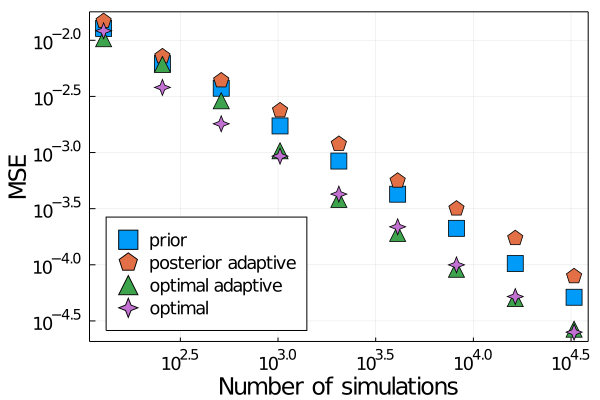

In [11]:

legendfontsize = 12
tickfontsize = 12
labelfontsize = 16
marker_size = 8

p = scatter()
for dict in all_result_dicts
    scatter!(total_ns, dict["error_means"],
        xscale = :log10,
        yscale = :log10,
        label = dict["label"],
        framestyle = :box,
        m = (marker_size, dict["marker"]),
        ylabel = "MSE",
        xlabel = "Number of simulations",
        legend = :bottomleft,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
end
plot(p)

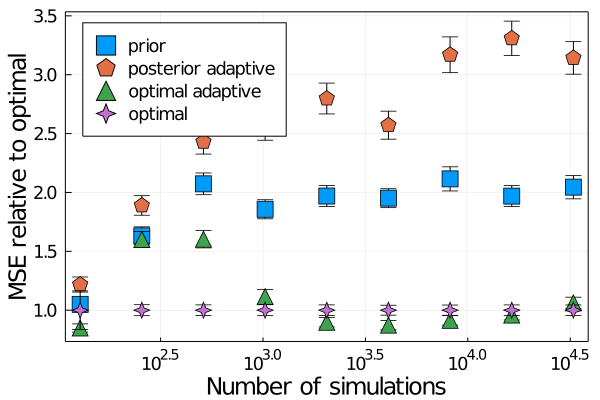

In [12]:
p = scatter()
for dict in all_result_dicts
    
    scatter!(total_ns, dict["error_means"]./targeted_dict["error_means"],
        xscale = :log10,
        yerr = sqrt.(dict["error_vars"]./num_trials)./targeted_dict["error_means"],
        label = dict["label"],
        framestyle = :box,
        m = (marker_size, dict["marker"]),
        ylabel = "MSE relative to optimal",
        xlabel = "Number of simulations",
        legend = :topleft,
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
end
plot(p)


### Comparing to prediction

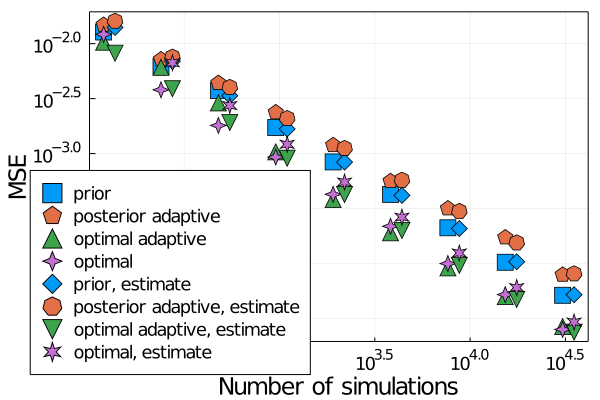

In [13]:
p = scatter()

for (i, dict) in enumerate(all_result_dicts)
    scatter!(total_ns.*10^(-0.03), dict["error_means"],
        color = i,
        xscale = :log10,
        yscale = :log10,
        label = dict["label"],
        framestyle = :box,
        marker = (dict["marker"], marker_size),
        ylabel = "MSE",
        xlabel = "Number of simulations",
        legend = (-0.03, 0.45),
        yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
        xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
    )
end
for (i, dict) in enumerate(all_result_dicts)
    # separate loops so estimates are on top
    scatter!(reverse(total_ns).*10^(0.03), reverse(dict["estimate_means"]),
        color = i,
        label = dict["label"]*", estimate",
        marker = (dict["estimate_marker"], marker_size),)
end
plot(p)

### Comparing to prediction at individual level

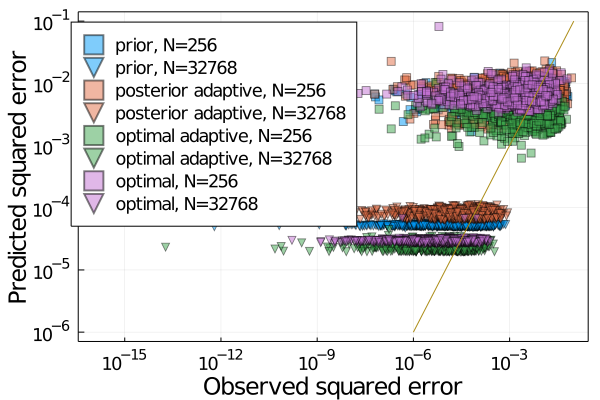

In [14]:
p = scatter()
markers = filter((m->begin
                m in Plots.supported_markers()
            end), Plots._shape_keys)
for (color, dict) in enumerate(all_result_dicts)
    for ns_index in [2, length(total_ns)]
        scatter!(dict["errors"][ns_index], dict["estimates"][ns_index],
            color = color,
            m = markers[ns_index],
            label = dict["label"]*", N="*string(total_ns[ns_index]),
            alpha = 0.5)
    end
end

linemin = 10^(-6)
linemax = 10^(-1)
plot!([linemin, linemax], [linemin, linemax], color = 5, label = nothing)
plot(p,
    framestyle = :box,
    xscale = :log10,
    yscale = :log10,
    xlim = [10^(-16), :auto],
    legend = (0.075,0.9),
    xlabel = "Observed squared error",
    ylabel = "Predicted squared error",
    yguidefontsize = labelfontsize, ytickfontsize = tickfontsize, legendfontsize = legendfontsize, 
    xguidefontsize = labelfontsize, xtickfontsize = tickfontsize,
)